In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup


## Prequisities 

The open-sesame command to run this pipetask:
```
source /u/ek/echarles/lsst/software/stable/config/lsst.bashrc
lsst_setup w_2021_16
```
In addition to the normal setup, we need to enable mixcoatl by commanding
```
export PYTHONPATH="/gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/mixcoatl/python":${PYTHONPATH}
```
The yaml file I used is here: https://github.com/youtsumi/ButlerGen3Work/blob/master/cpSpot2.yaml

And then the comamnd to run (the following command only runs for a single image)
```
pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781 \
    -d "instrument='LSSTCam' AND detector=29 AND exposure.observation_type='spot' AND exposure.science_program IN ('12788') AND exposure.seq_num=1820" \
    -o u/youtsumi/spot/20210504a \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types
```

If you strip off the part of ' AND exposure.seq_num=1820' it will process all the images in the run 12788

I used the following command to process all the images belonging to runs 12784, 12785, 12788, 12789
```
pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781 \
    -d "instrument='LSSTCam' AND detector=29 AND exposure.observation_type='spot' AND exposure.science_program IN ('12784', '12785', '12788', '12789')" \
    -o u/youtsumi/spot/Nov2020 \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types -j 4
```


The mixcoatl version I used was
https://github.com/youtsumi/mixcoatl/

You can prune Run collection by commanding like
```
butler prune-collection /sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml u/youtsumi/spot/junk/20210506T014808Z  --purge --unstore
```

## After the pipetask finished, we will explore what are generated in this Jupyter Notebook

First we will see what's collection available in this Butler repository

In [2]:
# Import necessary libraries
from lsst.daf.butler import Butler
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import numpy

# point to the Repo we are working on, these lines will print out what's in the Repo.
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/youtsumi/calib/bias/run_12781
u/youtsumi/calib/bias/run_12781/20210524T171403Z
u/youtsumi/calib/bias/run_12781/20210524T182233Z
u/youtsumi/calib/bias/run_12781/20210524T185436Z
LSSTCam/calib
LSSTCam/calib/unbounded
u/youtsumi/calib/bias/run_12781/20210524T193644Z
u/youtsumi/calib/bias/run_12781/20210524T214331Z
u/youtsumi/calib/bias/run_12781/20210524T224535Z
u/youtsumi/calib/bias/run_12781/20210525T004846Z
u/youtsumi/calib/bias/run_12781/20210525T163108Z
u/youtsumi/calib/bias/run_12781/20210525T170205Z
u/jchiang/calib/bias/run_12781
u/jchiang/calib/bias/run_12781/20210525T184949Z
/calib/run_12781
u/youtsumi/calib/dark/run_12781
u/youtsumi/calib/dark/run_12781/20210526T043740Z
u/youtsumi/calib/dark/run_12781/20210526T043948Z
u/youtsumi/calib/defects/run_12781
u/youtsumi/calib/defects/run_12781/20210526T044742Z
u/youtsumi/calib/defects/run_12781/20210526T045217Z
u/youtsumi/spot/1st
u/youtsumi/spot/1st/20210526T052357Z


In [3]:
# Specify collection. I know 'u/youtsumi/spot/20210504b' is the one. So pick it
collections = 'u/youtsumi/spot/1st'
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
#collections = 'u/youtsumi/calib/bias/run_12781/20210507T222346Z'
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

59139 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
4181 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCalib

Load all catalog onto memory, will take an hour

In [5]:
where = """
instrument='LSSTCam'
and detector=29
and exposure.observation_type = 'spot'
and exposure.science_program IN ('12788')
"""

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs[:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        if img.min()<22000:
            raise
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001015/MC_C_20201125_001015_R10_S02.fits(MC_C_20201125_001015): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001016/MC_C_20201125_001016_R10_S02.fits(MC_C_20201125_001016): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001017/MC_C_20201125_001017_R10_S02.fits(MC_C_20201125_001017): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001018/MC_C_20201125_001018_R10_S02.fits(MC_C_20201125_001018): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001019/MC_C_20201125_001019_R10_S02.fits(MC_C_20201125_001019): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201125/MC_C_20201125_001020/MC_C_20201125_001020_R10_S02.fits(MC_C_20201125_001020): Unable to determine the filte

Display a result

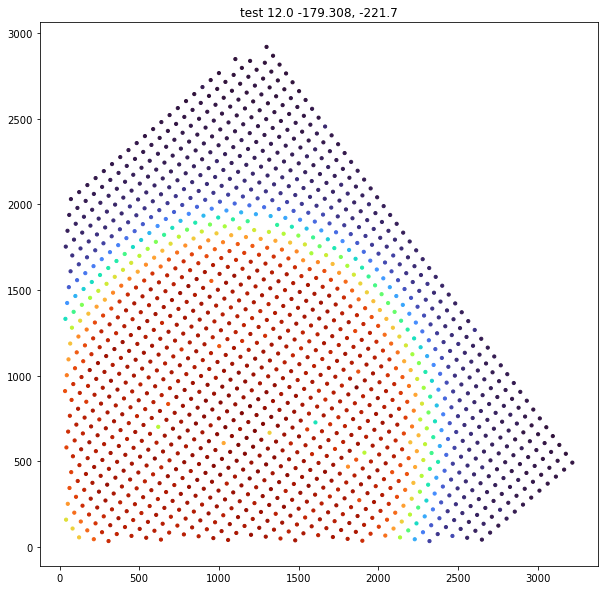

In [6]:
acat = results[0]["src"]
md = results[0]["md"]
fig = plt.figure(figsize=(10,10))
plt.title("{} {} {}, {}".format(
    "test",
    md["EXPTIME"],
    md["BOTXCAM"],
    md["BOTYCAM"]
))

fluxkey = "base_CircularApertureFlux_35_0_instFlux"

x, y = acat["spotgrid_x"], acat["spotgrid_y"]
I = acat[fluxkey]
plt.scatter( x, y, c=(I/numpy.nanmax(I)), s=10,cmap='turbo')


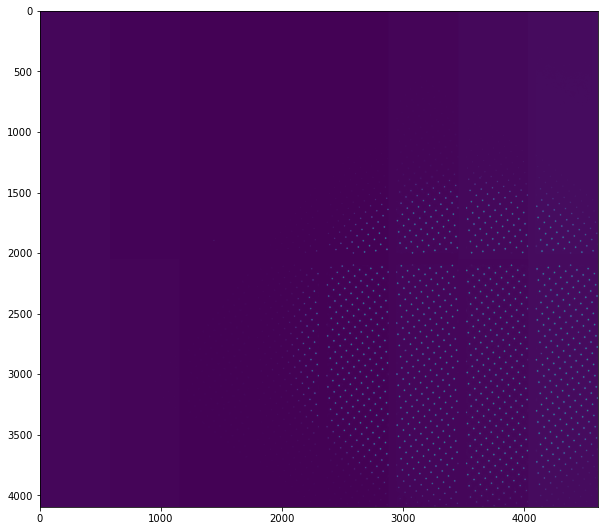

In [7]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_21/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'base_CircularApertureFlux_35_0_instFlux')

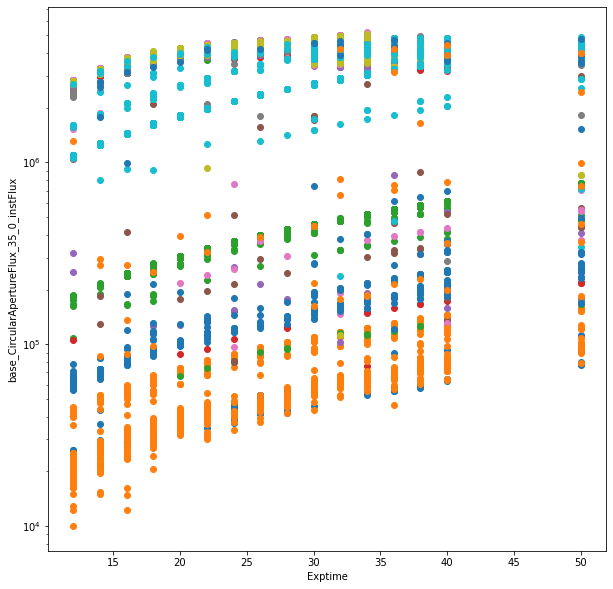

In [8]:
from astropy.table import Table, join, hstack
indexes = numpy.arange(2400)
basetable = ( Table( [ indexes+1,], names=("Index",) ) )

# sorting tables, padding missing, and joining tables in an order of fiducial spots
arr = []
for aresult in results:
    table = (Table( [
            aresult["src"]["spotgrid_index"],
            aresult["src"][fluxkey] 
        ],
        names=("Index","Iarr"),
        meta={ "exptime": aresult["md"]["EXPTIME"] } ))
    arr.append( join( basetable, table, keys="Index", join_type="left" )["Iarr"] )
arr = hstack([*arr])

# plots each spot fluxes as a function of exposure time
fig = plt.figure(figsize=(10,10))
for i in indexes[::200]:
    I = list(arr[i].values())
    plt.plot( [ aresult["md"]["EXPTIME"] for aresult in results ] , I, "o" )

plt.semilogy()
plt.xlabel( "Exptime" )
plt.ylabel( fluxkey )

[]

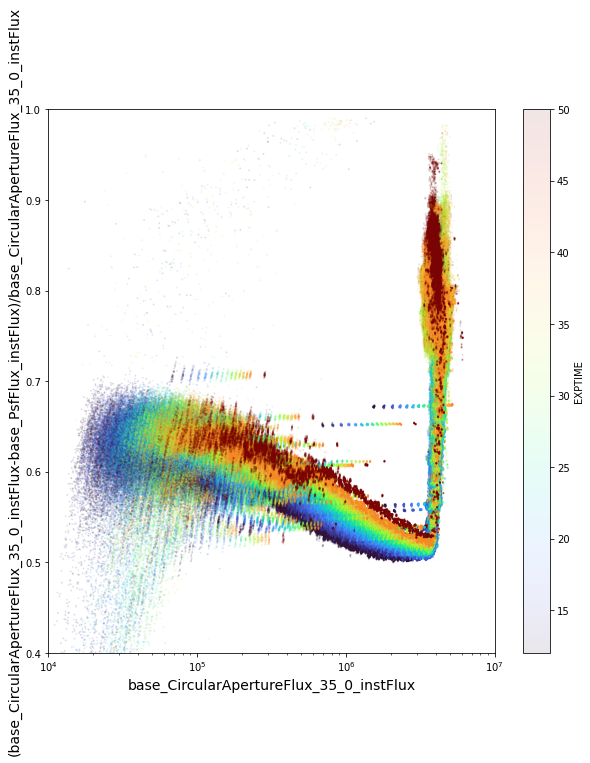

In [9]:
fig = plt.figure(figsize=(10,10))
fontsize=14
ykey="base_PsfFlux_instFlux"
xkey="base_CircularApertureFlux_35_0_instFlux"
x = []
y = []
e = []
for aresult in results[:]:
    cond = aresult["src"]["spotgrid_index"]>=0    
    x.extend(aresult["src"][xkey][cond])
    y.extend(aresult["src"][ykey][cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,(x-y)/x,c=e,s=1,cmap='turbo',alpha=0.1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("({}-{})/{}".format(xkey,ykey,xkey),fontsize=fontsize)
plt.xlim(1e4,1e7)
plt.ylim(0.4,1.0)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
plt.semilogx()

[]

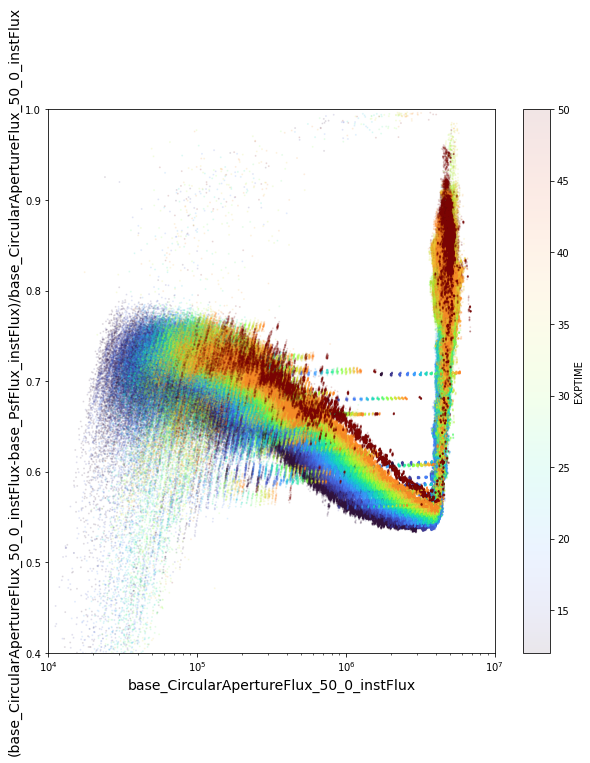

In [10]:
fig = plt.figure(figsize=(10,10))

ykey="base_PsfFlux_instFlux"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"

x = []
y = []
e = []
for aresult in results[:]:
    cond = aresult["src"]["spotgrid_index"]>=0
    x.extend(aresult["src"][xkey][cond])
    y.extend(aresult["src"][ykey][cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,(x-y)/x,c=e,s=1,cmap='turbo',alpha=0.1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("({}-{})/{}".format(xkey,ykey,xkey),fontsize=fontsize)
plt.xlim(1e4,1e7)
plt.ylim(0.4,1.0)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
plt.semilogx()

[]

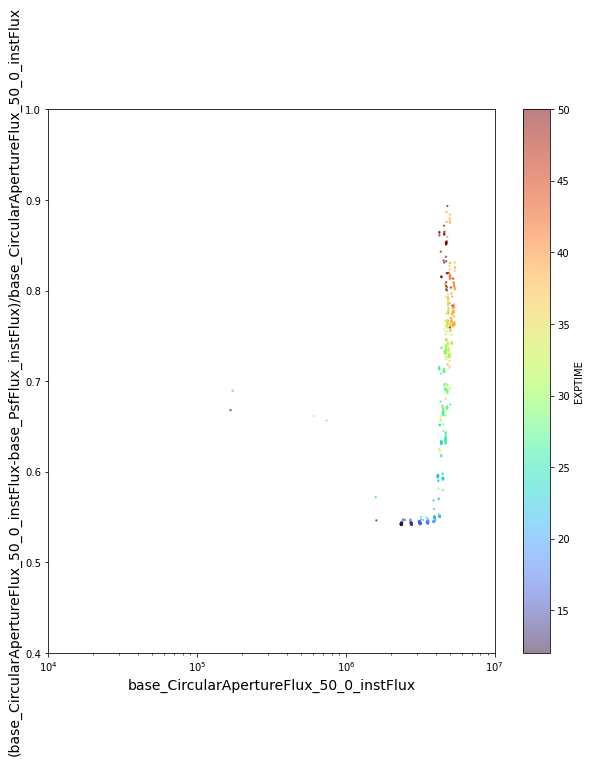

In [11]:
fig = plt.figure(figsize=(10,10))

ykey="base_PsfFlux_instFlux"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"

x = []
y = []
e = []
for aresult in results[:]:
    cond = aresult["src"]["spotgrid_index"]==410
    x.extend(aresult["src"][xkey][cond])
    y.extend(aresult["src"][ykey][cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,(x-y)/x,c=e,s=2,cmap='turbo',alpha=0.5)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("({}-{})/{}".format(xkey,ykey,xkey),fontsize=fontsize)
plt.xlim(1e4,1e7)
plt.ylim(0.4,1.0)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
plt.semilogx()

In [12]:
numofspots = numpy.array([ len(aresult["src"]["spotgrid_index"]>=0) for i, aresult in enumerate(results) ])
numpy.argsort(numofspots)[::-1]

array([1193, 1212, 1184, ...,    9,    7,    6])

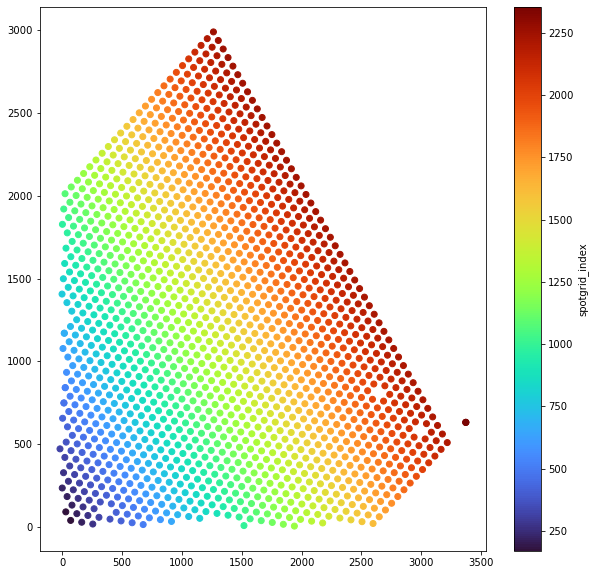

In [13]:
fig = plt.figure(figsize=(10,10))
aresult = results[200]
src = aresult["src"]
plt.scatter( src["spotgrid_x"], src["spotgrid_y"],
           c = src["spotgrid_index"],
           cmap='turbo')
plt.colorbar(label="spotgrid_index")


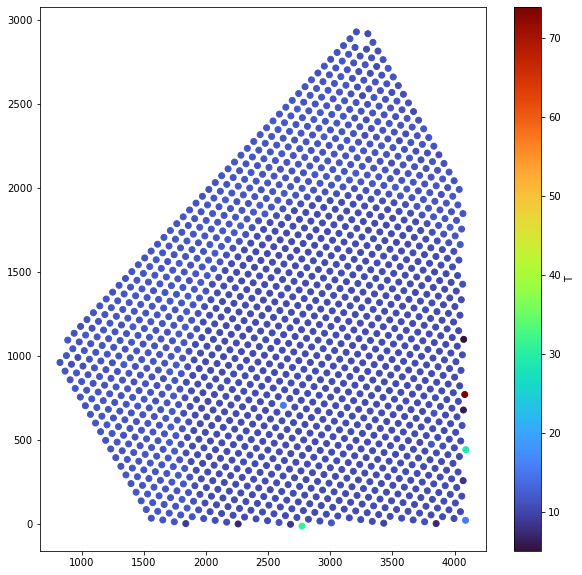

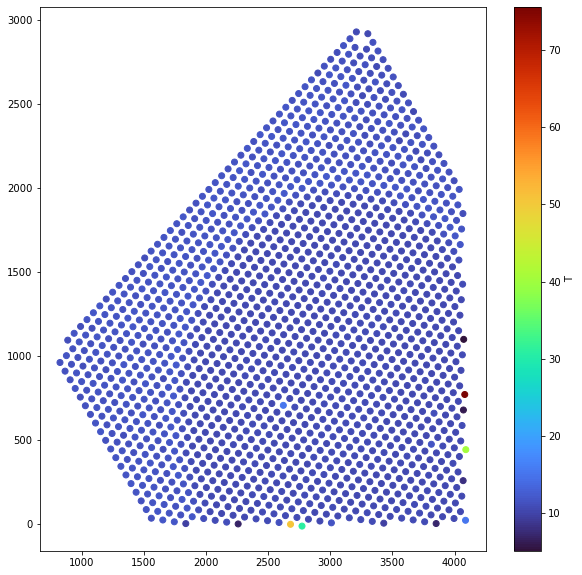

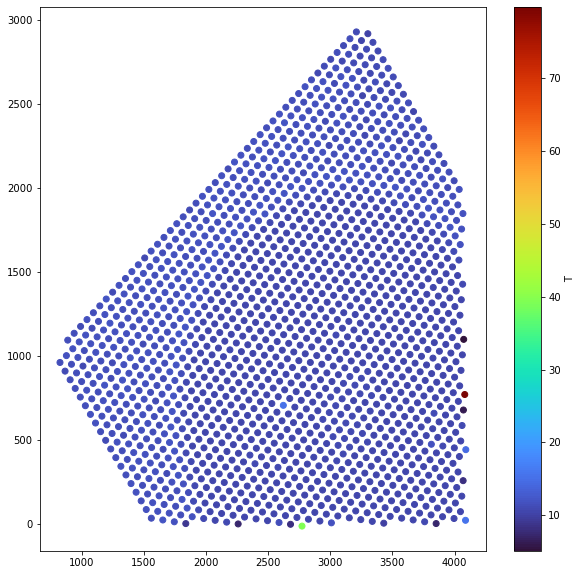

<Table length=1570>
  id  coord_ra coord_dec ... spotgrid_normalized_dx spotgrid_index
        rad       rad    ...                                      
int64 float64   float64  ...        float64             int32     
----- -------- --------- ... ---------------------- --------------
  764      nan       nan ...   -0.03433158965937726           1978
 1396      nan       nan ...                    nan    -2147483648
  163      nan       nan ...                    nan    -2147483648
  450      nan       nan ...  -0.005957820832254007           1777
 1267      nan       nan ...                    nan    -2147483648
  732      nan       nan ...                    nan    -2147483648
  291      nan       nan ...   -0.19708316122427613           1676
  165      nan       nan ...  0.0010626578873215266           1576
 1562      nan       nan ...                    nan    -2147483648
  ...      ...       ... ...                    ...            ...
 1054      nan       nan ...                    nan    -2147483648
 1570      nan       nan ...                    nan    -2147483648
    5      nan       nan ...     0.2858382228060676            703
  515      nan       nan ...    -0.2617063639640274           1827
    7      nan       nan ...                    nan    -2147483648
   10      nan       nan ...                    nan    -2147483648
   12      nan       nan ...                    nan    -2147483648
  584      nan       nan ...                    nan    -2147483648
    8      nan       nan ...                    nan    -2147483648
  230      nan       nan ...                    nan    -2147483648

In [14]:
for i in [600,601,602]:
    fig = plt.figure(figsize=(10,10))
    aresult = results[i]
    key="T"
    src = aresult["src"]
    T=src["base_SdssShape_xx"]+src["base_SdssShape_yy"]
    
    plt.scatter( src["spotgrid_x"], src["spotgrid_y"],
               c = T,
               cmap='turbo')
    plt.colorbar(label=key)
    plt.show()
tab = aresult["src"].asAstropy()
tab.sort("base_SdssShape_xx")
tab

<ipython-input-15-1a236dda4739>:38: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(targets),1,i+1,sharex=plt.subplot("{}11".format(len(targets))))


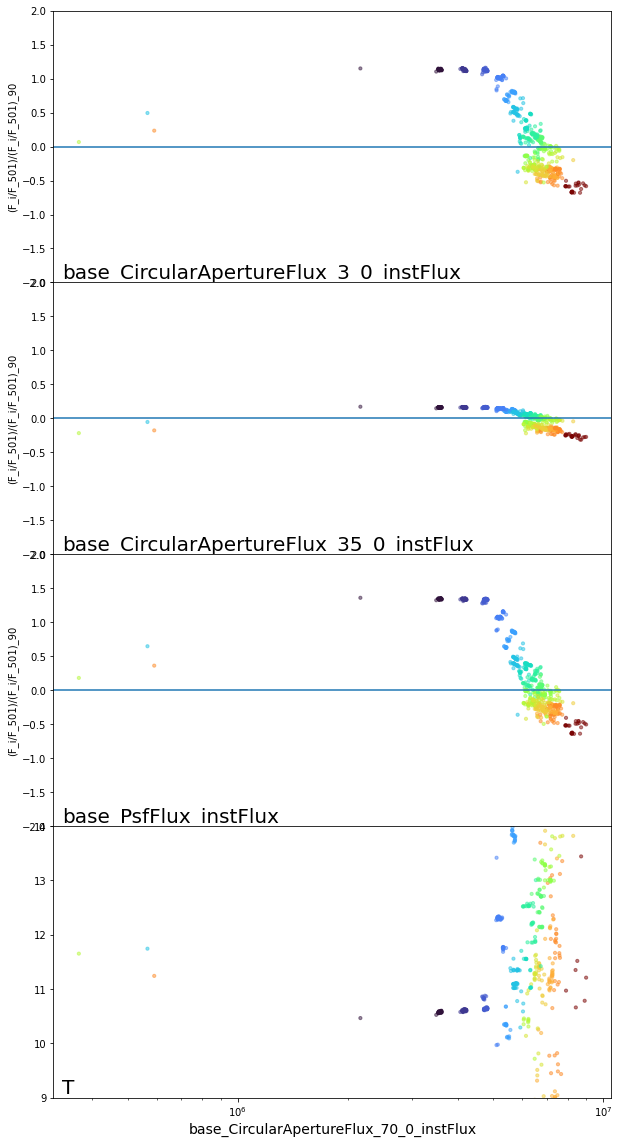

In [15]:
fig = plt.figure(figsize=(10,20))

spot1 = 501 # base
for spot2 in numpy.arange(750,850):
    targets = [
            "base_CircularApertureFlux_3_0_instFlux",
#            "base_CircularApertureFlux_12_0_instFlux",
            "base_CircularApertureFlux_35_0_instFlux",
            "base_PsfFlux_instFlux",
            "T"
        ]
    for i, ykey in enumerate(targets):
        xkey="base_CircularApertureFlux_70_0_instFlux"

        x = []
        y = []
        e = []
        for aresult in results[:]:
            xtmp = aresult["src"][xkey][aresult["src"]["spotgrid_index"]==spot2]
            if len(xtmp)==1:
                x.append(xtmp[0])
            else:
                x.append(numpy.nan)
            if ykey == "T":
                ytmp = aresult["src"][aresult["src"]["spotgrid_index"]==spot2]
                ytmp = ytmp["base_SdssShape_xx"]+ytmp["base_SdssShape_yy"]
            else:
                ytmp = aresult["src"][ykey][aresult["src"]["spotgrid_index"]==spot2]

            if len(ytmp)==1:
                y.append(ytmp[0])
            else:
                y.append(numpy.nan)
            e.extend([aresult["md"]["EXPTIME"]]*len([1]))
        x=numpy.array(x)
        y=numpy.array(y)
        
        ax = plt.subplot(len(targets),1,i+1,sharex=plt.subplot("{}11".format(len(targets))))
        if ykey=="T":        
            ax.scatter(x,y,c=e,s=10,cmap='turbo',alpha=0.5)
            plt.ylim(9,14)
        else:
            p=numpy.nanpercentile((y/x),90)    
            yh = numpy.nanmedian((y/x)[numpy.where((y/x)<p)])        
            ax.scatter(x,(y/x)/yh-1,c=e,s=10,cmap='turbo',alpha=0.5)
            plt.ylim(-2,2)
            ax.axhline(0)
            ax.set_ylabel("(F_{0}/F_{1})/(F_{0}/F_{1})_90".format("i",spot1))
            
        ax.set_xlabel(xkey,fontsize=fontsize)
        ax.annotate(ykey,(0.015,0.015),xycoords='axes fraction',fontsize=20)

#        plt.xlim(1e6,None)
        ax.semilogx()
    
plt.subplots_adjust(hspace=0)

[]

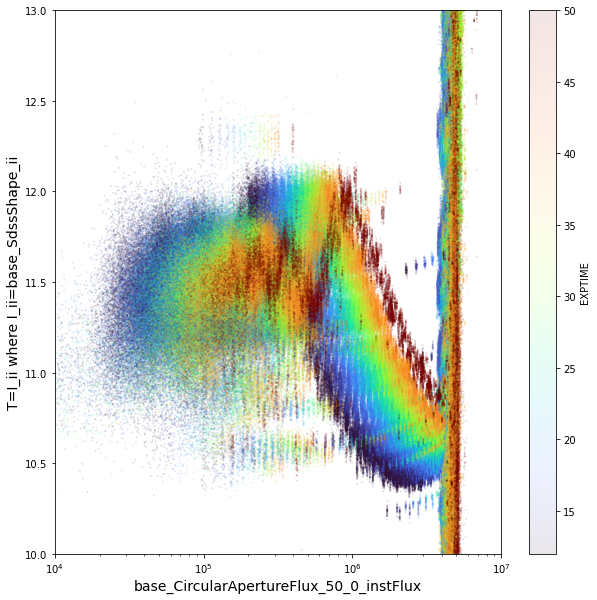

In [16]:
fig = plt.figure(figsize=(10,10))

#ykey="ext_shapeHSM_HsmShapeRegauss_sigma"
ykey="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"
x = []
y = []
e = []
for aresult in results[:]:
    cond = aresult["src"]["spotgrid_index"]>=0
    x.extend(aresult["src"][xkey][cond])
    y.extend((aresult["src"][ykey]+aresult["src"][y2key])[cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,y,c=e,s=1,cmap='turbo',alpha=0.1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("{}".format("T=I_ii where I_ii=base_SdssShape_ii"),fontsize=fontsize)
plt.xlim(1e4,1e7)
plt.ylim(10,13)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
#plt.loglog()
plt.semilogx()

In [17]:
from astropy.table import vstack, join
faint = []
for aresult in results:
    if aresult["md"]["EXPTIME"]>13:
        continue
    faint.append(aresult["src"].asAstropy())
mean_data_table = vstack(faint, join_type='exact')

In [18]:
mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_21/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Table length=2397>
   id   coord_ra coord_dec ... spotgrid_normalized_dx spotgrid_index
          rad       rad    ...                                      
float64 float64   float64  ...        float64             int32     
------- -------- --------- ... ---------------------- --------------
    2.0      nan       nan ...   0.007305227558736277              0
    5.0      nan       nan ...   0.008187562547542002              1
    8.0      nan       nan ...   0.008438984185722528              2
   12.0      nan       nan ...  0.0049871077853354305              3
   18.0      nan       nan ...   0.004235989789211722              4
   25.0      nan       nan ...  0.0016604193276970112              5
   33.0      nan       nan ...    0.00218641828603321              6
   42.0      nan       nan ... -0.0001762759232067857              7
   53.0      nan       nan ...   0.003772409855721613              8
    ...      ...       ... ...                    ...            ...
 1456.0      nan       nan ...  -0.005065953592132276           2390
 1470.0      nan       nan ...  -0.009536619183674603           2391
 1482.0      nan       nan ...  -0.013203401511362999           2392
 1493.0      nan       nan ...   -0.01297162099529716           2393
 1502.0      nan       nan ...  -0.014042441255648965           2394
 1510.0      nan       nan ...  -0.013281497390034617           2395
 1517.0      nan       nan ...  -0.012479658477305203           2396
 1522.0      nan       nan ...  -0.016228391047007535           2397
 1526.0      nan       nan ...   -0.01745595088623237           2398
 1526.0      nan       nan ...   -0.01629538446614543           2399

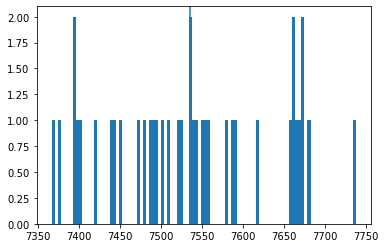

In [19]:
src = mean_data_table[mean_data_table["spotgrid_index"]==2395]
plt.hist( src["base_PsfFlux_instFlux"],bins=100 )
plt.axvline( numpy.nanmedian( src["base_PsfFlux_instFlux"]) )

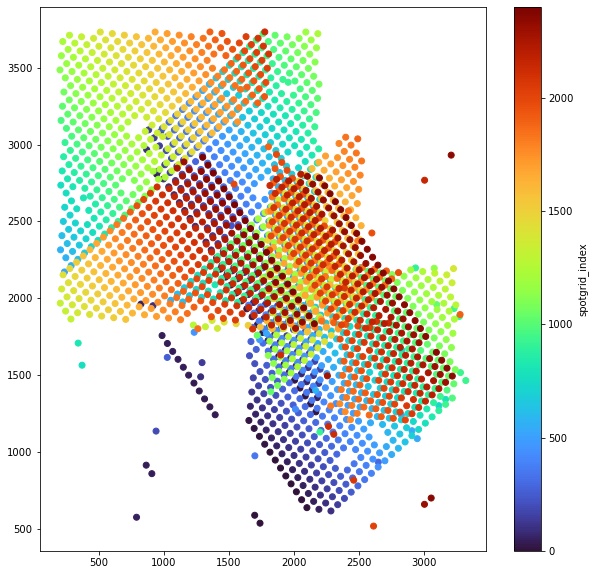

In [20]:
fig = plt.figure(figsize=(10,10))
src = ref
plt.scatter( src["spotgrid_x"], src["spotgrid_y"],
           c = src["spotgrid_index"],
           cmap='turbo')
plt.colorbar(label="spotgrid_index")

In [21]:
tab=mean_data_table[mean_data_table["spotgrid_index"]>=0]
tab.sort("base_SdssShape_xxErr")
tab

<Table length=133099>
  id  coord_ra coord_dec ... spotgrid_normalized_dx spotgrid_index
        rad       rad    ...                                      
int64 float64   float64  ...        float64             int32     
----- -------- --------- ... ---------------------- --------------
  761      nan       nan ...   -0.03464544680182614           1978
  759      nan       nan ...   -0.03581491480945049           1978
  759      nan       nan ...  -0.032269158285870764           1978
  761      nan       nan ...   -0.03546829660096423           1978
  756      nan       nan ...   -0.03509048196153548           1978
  757      nan       nan ...  -0.035666861132617786           1978
  759      nan       nan ...   -0.03550648736563539           1978
  757      nan       nan ...  -0.035964661703754564           1978
  760      nan       nan ...  -0.036071232806405264           1978
  ...      ...       ... ...                    ...            ...
    8      nan       nan ...    0.06810154427538455           1137
    5      nan       nan ...     0.2693830103595866            703
   11      nan       nan ...   -0.05059053340238276           1378
   41      nan       nan ...    0.38108349489874144            297
   11      nan       nan ...   -0.03820114281099772           1378
    5      nan       nan ...    0.27843853554327547            703
   11      nan       nan ...    -0.0515325862636223           1378
   11      nan       nan ...  -0.052983515524622896           1378
   11      nan       nan ...   -0.05099052960410736           1378
   11      nan       nan ...   -0.05243237234118096           1378

[]

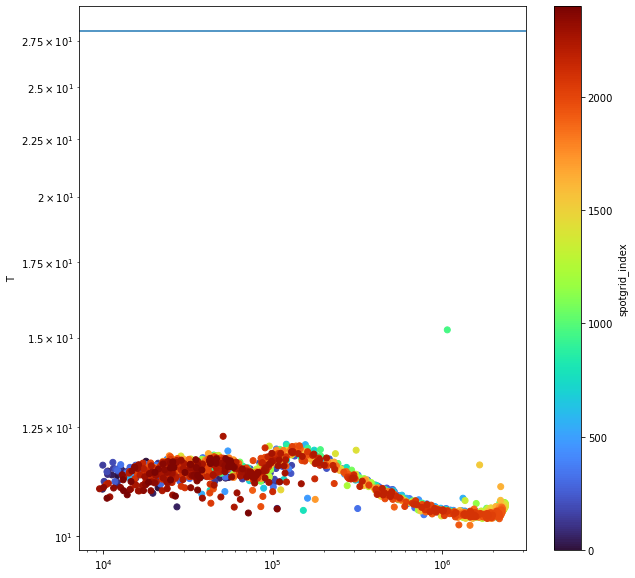

In [22]:
fig = plt.figure(figsize=(10,10))

cond = mean_data_table["spotgrid_index"]<2400
plt.scatter(
    ref["base_SdssShape_instFlux"],
    ref["base_SdssShape_xx"]+ref["base_SdssShape_yy"],
#    ref["base_PsfFlux_area"],
    c = ref["spotgrid_index"],
    cmap='turbo'
)
plt.colorbar(label="spotgrid_index")
x=numpy.median(mean_data_table["base_PsfFlux_area"])
s=numpy.std(mean_data_table["base_PsfFlux_area"])
plt.ylabel("T")
plt.axhline( x-0.8*s )
plt.loglog()

<ipython-input-62-a26c680049a2>:27: RuntimeWarning: invalid value encountered in true_divide
  y = (bx-bx[minid])/(sy-sy[minid])


[-179.308 -179.308 -179.308 ... -159.308 -159.308 -159.308] [0.01022926 0.01022746 0.01022856 ... 0.         0.         0.        ] [1679.91876711 1679.57336691 1679.78488936 ... 3684.32995165 3684.28748023
 3684.30450664] 3635.093618830899


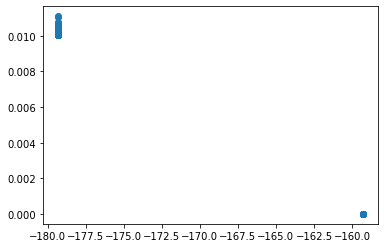

In [62]:
bx = []
by = []
sx = []
sy = []
for aresult in results:
    cond = aresult["src"]["spotgrid_index"]==1218
    BOTXCAM = aresult["md"]["BOTXCAM"]
    BOTYCAM = aresult["md"]["BOTYCAM"]
    spotgrid_x = aresult["src"]["spotgrid_x"][cond]
    spotgrid_y = aresult["src"]["spotgrid_y"][cond]
    if ( len( spotgrid_x ) > 0 ):
        spotgrid_x = spotgrid_x[0]
        spotgrid_y = spotgrid_y[0]
    else:
        spotgrid_x = numpy.nan
        spotgrid_y = numpy.nan
    bx.append(BOTXCAM)
    by.append(BOTYCAM)
    sx.append(spotgrid_x)
    sy.append(spotgrid_y)
bx=numpy.array(bx)    
by=numpy.array(by)
sx=numpy.array(sx)
sy=numpy.array(sy)

minid = numpy.argsort(sy)[len(sy)//2] # numpy.nanargmedian(sy)
y = (bx-bx[minid])/(sy-sy[minid])
plt.plot(bx,y,"o")
print(bx,y, sy, sy[minid])

<ipython-input-23-022e96e936b0>:68: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-23-022e96e936b0>:75: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


<Figure size 720x720 with 0 Axes>

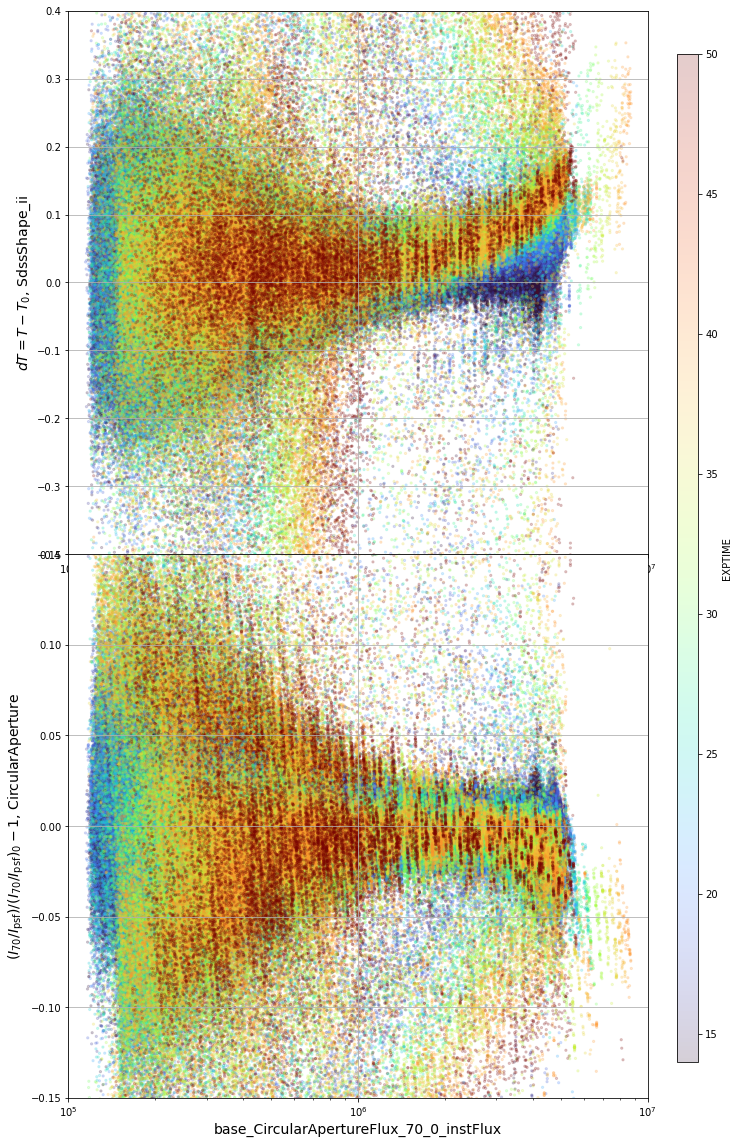

In [23]:
fig = plt.figure(figsize=(10,10))

from astropy.table import vstack, join

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_3_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

  
x = []
y = []
zl = []
zs = []
e = []
for aresult in results[:]:
    if aresult["md"]["EXPTIME"]<=13:
        continue
    joined = join(aresult["src"].asAstropy(),ref,keys="spotgrid_index")
    Iperr = joined["base_PsfFlux_instFluxErr_1"]
    Ip = joined["base_PsfFlux_instFlux_1"]    
    Ierr = joined["{}Err_1".format(xkey)]
    I = joined["{}_1".format(xkey)]    
    joined = joined[
        numpy.where( 
            (joined["base_PixelFlags_flag_1"] == False) &
            (joined["base_PsfFlux_flag_edge_1"] == False) &
            (joined["base_CircularApertureFlux_70_0_flag_apertureTruncated_1"] == False) &            
            (joined["base_ClassificationExtendedness_flag_1"] == False) &
            (joined["base_PixelFlags_flag_1"] == False) &            
            (joined["base_PixelFlags_flag_offimage_1"] == False) &
            (joined["base_PixelFlags_flag_edge_1"] == False) &
            (joined["base_PixelFlags_flag_interpolated_1"] == False) &
            (joined["base_PixelFlags_flag_saturated_1"] == False) &            
            (joined["base_PixelFlags_flag_cr_1"] == False) &
            (joined["base_PixelFlags_flag_bad_1"] == False) &
            (joined["base_PixelFlags_flag_suspect_1"] == False) &
            (joined["base_PixelFlags_flag_interpolatedCenter_1"] == False) &
            (joined["base_PixelFlags_flag_saturatedCenter_1"] == False) &
            (joined["base_PixelFlags_flag_crCenter_1"] == False) &
            (joined["base_PixelFlags_flag_suspectCenter_1"] == False) &
            (joined["spotgrid_x_1"] > 100 ) &
            (joined["spotgrid_y_1"] > 100 ) &
            (joined["spotgrid_x_1"] < 3900 ) &
            (joined["spotgrid_y_1"] < 3900 ) &
            (Iperr/Ip<0.01)&
            (Ierr/I<0.01)            
        )
    ]
    x.extend(joined["{}_1".format(xkey)])
    Y1=joined["{}_1".format(y1key)]
    Y2=joined["{}_1".format(y2key)]
    Y0_1=joined["{}_2".format(y1key)]
    Y0_2=joined["{}_2".format(y2key)]    
    zl.extend(joined["{}_1".format(zlkey)]/joined["{}_2".format(zlkey)])
    zs.extend(joined["{}_1".format(zskey)]/joined["{}_2".format(zskey)])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([aresult["md"]["EXPTIME"]]*len(Y1))
    
x=numpy.array(x)
y=numpy.array(y)
zl=numpy.array(zl)
zs=numpy.array(zs)

fig = plt.figure(figsize=(10,20))

ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=5,cmap='turbo',alpha=0.2)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
ax.set_xlim(1e5,1e7)
ax.set_ylim(-0.4,0.4)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=5,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
bx.set_xlim(1e5,1e7)
bx.set_ylim(-.15,.15)
plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

<ipython-input-24-3f2418061103>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-24-3f2418061103>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


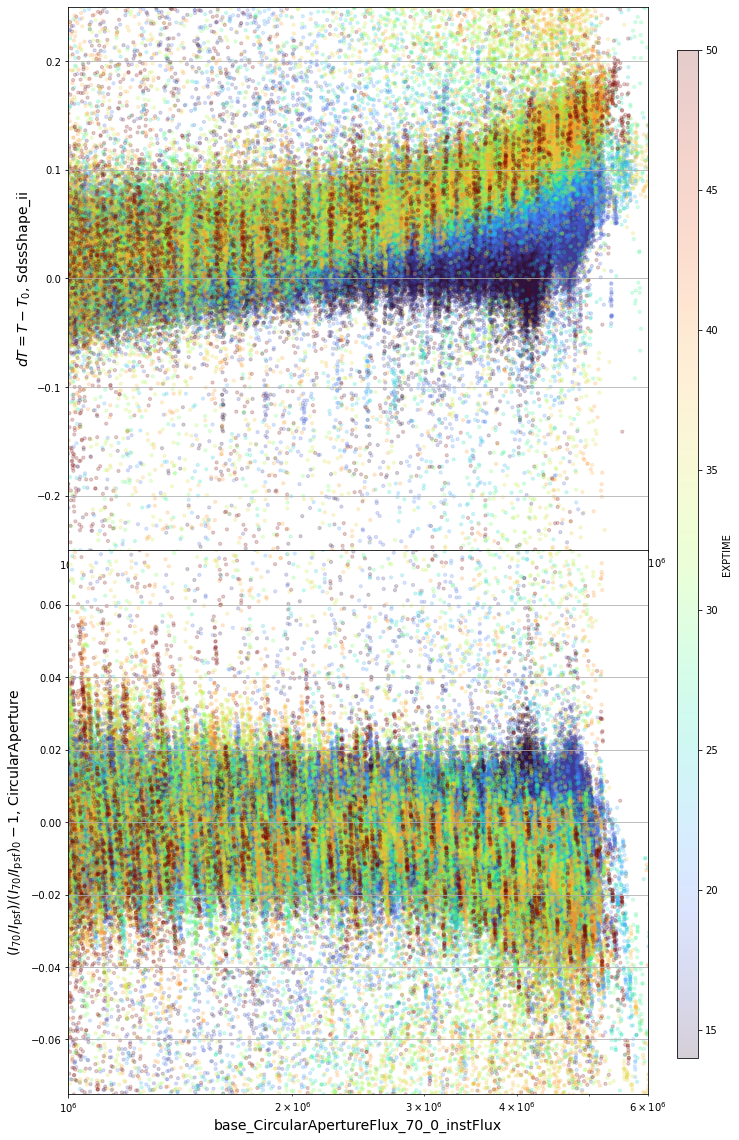

In [24]:
fig = plt.figure(figsize=(10,20))

ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=10,cmap='turbo',alpha=0.2)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
ax.set_xlim(1e6,1e7)
ax.set_ylim(-0.25,0.25)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=10,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
bx.set_xlim(1e6,0.6e7)
bx.set_ylim(-.075,.075)
plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

- Distribution of points shift towards right, means just getting brighter as exposure time increasing. This is expected.
- The distribution we see here is the actuall distribution of spot sizes. We are not seeing the real point star. So we see some distribution according to optical distortion.

Text(0, 0.5, 'base_CircularApertureFlux_35_0_instFlux')

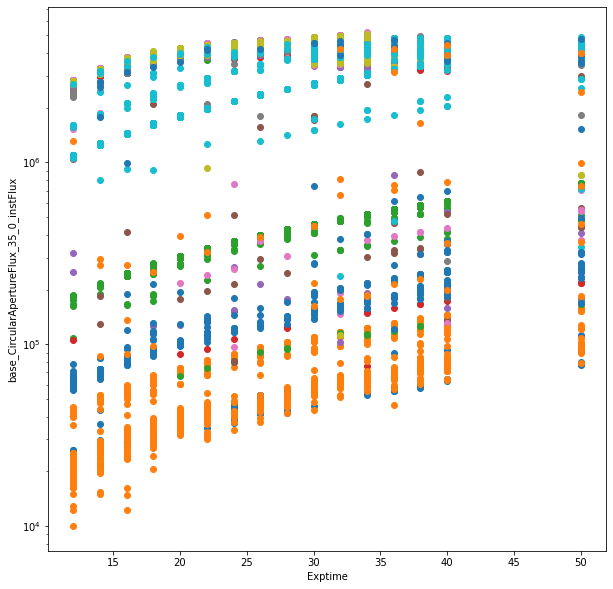

In [25]:
indexes = numpy.arange(2400)
basetable = ( Table( [ indexes+1,], names=("Index",) ) )

# sorting tables, padding missing, and joining tables in an order of fiducial spots
arr = []
for aresult in results:
    table = (Table( [
            aresult["src"]["spotgrid_index"],
            aresult["src"][fluxkey] 
        ],
        names=("Index","Iarr"),
        meta={ "exptime": aresult["md"]["EXPTIME"] } ))
    arr.append( join( basetable, table, keys="Index", join_type="left" )["Iarr"] )
arr = hstack([*arr])

# plots each spot fluxes as a function of exposure time
fig = plt.figure(figsize=(10,10))
for i in indexes[::200]:
    I = list(arr[i].values())
    plt.plot( [ aresult["md"]["EXPTIME"] for aresult in results ] , I, "o" )

plt.semilogy()
plt.xlabel( "Exptime" )
plt.ylabel( fluxkey )

```
(lsst-scipipe-0.5.0-ext) -bash-4.2$ butler query-dimension-records  /sdf/group/lsst/camera/IandT/repo_gen3/spot_test  detector | grep R22_S20
   LSSTCam  96   R22_S20          S20  R22   SCIENCE


pipetask run -d "instrument ='LSSTCam' AND exposure.observation_type = 'bias' AND exposure.science_program IN ( '12781' ) AND detector in ( 29, 96 ) AND exposure.seq_num=10" \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all \
    -o u/youtsumi/calib/bias/run_12781 \
    -p /gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/cpBias.yaml \
    --register-dataset-types \
    -j 8

PYTHONPATH=mixcoatl/python:$PYTHONPATH pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781_29_96 \
    -d "instrument='LSSTCam' AND detector in ( 29, 96 ) AND exposure.observation_type='spot' AND exposure.science_program IN ('12784', '12785', '12788', '12789')" \
    -o u/youtsumi/spot/Nov2020 \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types -j 8
    
butler certify-calibrations /sdf/group/lsst/camera/IandT/repo_gen3/spot_test u/youtsumi/calib/bias/run_12781_28_96 /calib/run_12781_28_96 bias

```

In [26]:
where = """
instrument='LSSTCam'
and detector=96
and exposure.observation_type = 'spot'
and exposure.science_program IN ('12789')
"""

# Specify collection. I know 'u/youtsumi/spot/20210504b' is the one. So pick it
collections = 'u/youtsumi/spot/Nov2020'
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
#collections = 'u/youtsumi/calib/bias/run_12781/20210507T222346Z'
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections,where=where))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )
        
datasetRefs = list(subregistry.queryDatasets(
        datasetType="spotSrc",
        collections=collections,
        where=where)
                  )


Error DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
Error DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
Error DatasetType('isr_config', {}, Config)
Error DatasetType('cpCombine_config', {}, Config)
Error DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
Error DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrume

MissingCollectionError: No collection with name 'u/youtsumi/spot/Nov2020' found.

In [ ]:
(butler.get(datasetRefs[0],collections=collections)).asAstropy()

In [ ]:
min([ aresult["md"]["EXPTIME"] for aresult in results ])
    